In [646]:
import csv
import shapefile
import shapely.geometry as geom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl

import math
import numpy as np
from numpy import linalg as la
import statistics as stat

import ternary
from ternary.helpers import simplex_iterator

In [698]:
def load_results(year):
    res = {}
    with open("PA/"+str(year) + "_county.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            county = row["County"]
            del row["County"]

            res[county] = row
    return res

COUNTY_RESULTS = load_results(2000)
print(COUNTY_RESULTS['Allegheny'])

{'Al Gore': 329565.0, 'Patrick Buchanan': 2106.0, 'Ralph Nader': 10536.0, 'Write-in': 0.0, 'Harry Browne': 941.0, 'George Bush': 234992.0, 'Howard Phillips': 3521.0}


In [699]:
# CLINTON = 'Clinton, Hillary'
# TRUMP = 'Trump, Donald J'

# CLINTON = 'Barack Obama'
# TRUMP = 'Mitt Romney'

CLINTON = 'Al Gore'
TRUMP = 'George Bush'

CANDIDATES = {
    2000: {"DEM": "foo", "REP": "doof"}
}

In [662]:
sf = shapefile.Reader("PA/tl_2011_us_county/tl_2011_us_county")
COUNTY_SHAPES = {}
iter = sf.iterShapeRecords()
for i in iter:
    if i.record[0] == '42':
        s = geom.shape(i.shape)
        COUNTY_SHAPES[i.record[4].capitalize()]=s
#         print(i.record[4].capitalize(),s.area)
        
print(len(COUNTY_SHAPES.keys()))

67


In [702]:
VOTERS = {}
with open("PA/2000_registerd_voters_county.csv",'r') as f:
    reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        VOTERS[row["County"].capitalize()] = row
VOTERS['Allegheny']

{'ALL': 914894.0,
 'CST': 10.0,
 'County': 'ALLEGHENY',
 'DEM': 568560.0,
 'LIB': 2388.0,
 'OTH': 83145.0,
 'REP': 260791.0}

In [715]:
dem_votes = sum([k[CLINTON] for k in COUNTY_RESULTS.values()])
rep_votes = sum([k[TRUMP] for k in COUNTY_RESULTS.values()])
total = sum([sum(k.values()) for k in COUNTY_RESULTS.values()])
winner = CLINTON
if rep_votes > dem_votes:
    winner = TRUMP
print(winner+" won the election by " + str(round(abs(dem_votes-rep_votes)/total*100, 2)) + "%")
print("there was a total of " + str(int(total)) + " votes cast")

Al Gore won the election by 4.22%
there was a total of 4911538 votes cast


In [ ]:
def plot_pa_data(colors, cmap=None, norm=None):
    if cmap is not None:
        fig = plt.figure()#figsize=(8, 3))
        ax = fig.add_axes([0.05, 0.05, 0.85, 0.9], projection=ccrs.PlateCarree())
        ax2 = fig.add_axes([0.925, 0.15, 0.05, 0.7])
    else:
        ax = plt.axes(projection=ccrs.PlateCarree())
        
    for county,v in COUNTY_SHAPES.items():
        color = colors[county]
        cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree())
        ax.add_feature(cf, facecolor=color)

    ax.set_extent([-80.5198510000000027,-74.7215190000000007,39.7211469999999949,42.5160720000000012])
    ax.set_aspect(1)
    if cmap is not None:
        cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='max')
    plt.show()

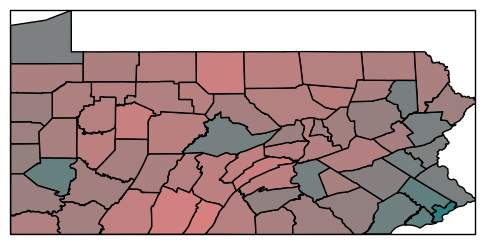

In [692]:
values = {}
for county,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    values[county] = (meta[TRUMP]/total,0.5,0.5)
plot_pa_data(values)

26298210.7138 24904.6963247


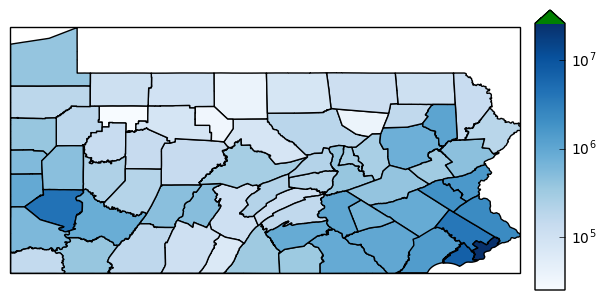

In [703]:

# ax = plt.axes(projection=ccrs.PlateCarree())
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

norm = colors.LogNorm()

to_plot = []
for county,v in COUNTY_SHAPES.items():
    vap = int(dict(VOTERS[county])["ALL"])
    value = vap/v.area
    to_plot.append((county, v, value))

norm.autoscale_None([k[2] for k in to_plot])
print(norm.vmax, norm.vmin)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)

values = {}
for (county, shape, value) in to_plot:
    color = sm.to_rgba(value)
    values[county] = color
#     print("sm:", k, value, color)

plot_pa_data(values, cmap=colormap, norm=norm)

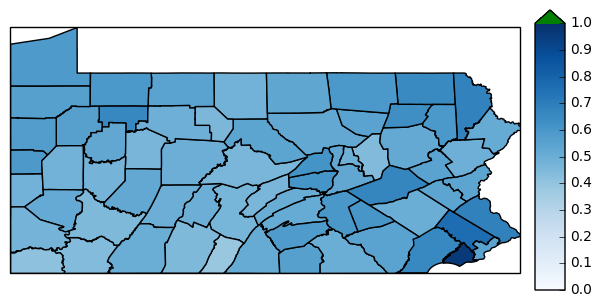

In [705]:
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

values = {}
for k,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[k]
    total = sum(meta.values())
    clinton = meta[CLINTON]
    trump = meta[TRUMP]
    vap = VOTERS[k]["ALL"]
#     color = total/vap
#     value = int(meta["CLINTON, HILLARY"])/int(VOTERS[k]["DEM"])
#     value = int(meta["TRUMP, DONALD J"])/int(VOTERS[k]["REP"])
#     value = int(meta["TRUMP, DONALD J"])/sum([int(VOTERS[k]["REP"]), int(VOTERS[k]["OTH"]), int(VOTERS[k]["NOF"])])
    value = trump/((vap-VOTERS[k]["DEM"])-(total-trump-clinton))
#     value = clinton/((vap-VOTERS[k]["REP"])-(total-trump-clinton))
    color = colormap(value)
    values[k] = color
    if value > 1:
        print(k, value)

plot_pa_data(values, cmap=colormap)

43.6116101417 -37.246870473


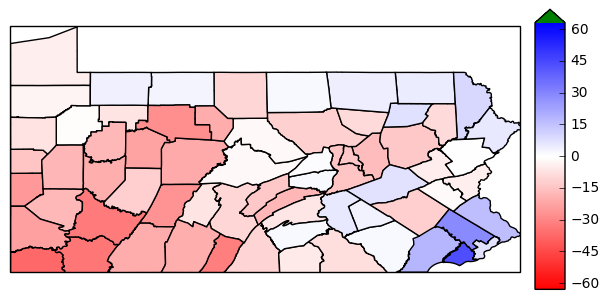

In [707]:
colormap = cm.get_cmap("bwr_r")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

norm = colors.Normalize()

to_plot = []
for county,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    clinton = meta[CLINTON]
    trump = meta[TRUMP]
    vap = VOTERS[county]["ALL"]
    
    republicans = VOTERS[county]["REP"]/vap*100
    democrats = VOTERS[county]["DEM"]/vap*100
    value = ((clinton-trump)/total*100)-(democrats-republicans)
    to_plot.append((county, v, value))

norm.autoscale_None([k[2] for k in to_plot])
print(norm.vmax, norm.vmin)
m = 63#max(abs(norm.vmax), abs(norm.vmin))
norm = colors.Normalize(vmin=-m, vmax=m)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)

values = {}
for (county, shape, value) in to_plot:
    color = sm.to_rgba(value)
    values[county] = color
#     print("sm:", k, value, color)

plot_pa_data(values, cmap=colormap, norm=norm)

[-17.380726480315275, -3.9634406913504083, -25.245740406944165, -13.485380066233224, -11.536414061103429, -4.570923557035691, -1.562866194008671, 43.611610141734644, -33.651394272900575, -14.661677880927272, -2.9311813067688846, 0.7680303003663624, 7.66894710720754, -13.646746137896539, -14.306279537528114, -17.729559683311724, -10.537306615922493, 4.890007767157126, -1.9192416887979986, -6.164470381953244, 1.4913950525951662, 3.640820675525685, -6.530856255130622, -0.8426024301807864, -17.463190414489375, 6.915654230134525, -9.12975289409222, -11.83644403815893, -6.766862861668262, 1.5816972987878586, -18.20393914306893, -22.71327245847025, 29.014989021720435, 9.76309577596053, -9.928762835130705, -19.859564274825207, -16.59283048864632, -27.016700526386522, -10.198356479378923, 3.973515945891581, 7.346933585356659, -20.24962909767704, 2.6690926888238735, -13.629196415215553, -8.010283379187111, -31.76397833547064, -32.639615220897774, -4.264909402280331, -0.4654638889459979, -9.00239

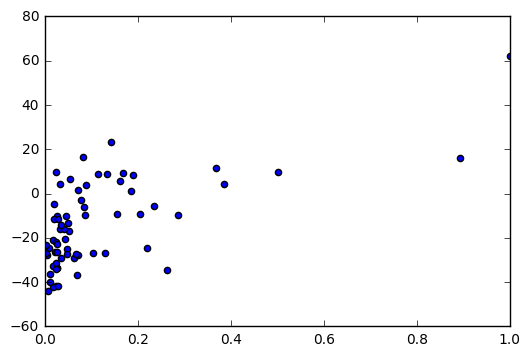

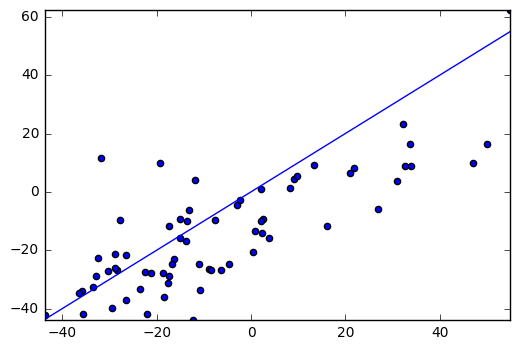

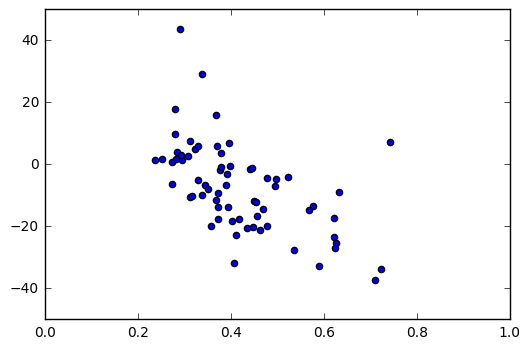

In [708]:
x=[]
clintons = []
trumps=[]
counties = COUNTY_RESULTS.keys()
vap=[int(dict(VOTERS[c])["ALL"]) for c in counties]
vap = [i/max(vap) for i in vap]

for county in COUNTY_RESULTS.keys():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    clinton = meta[CLINTON]
    trump = meta[TRUMP]
    x.append((clinton-trump)/total*100)
    trumps.append(trump/total*100)
    clintons.append(clinton/total*100)
#     x.append((total-clinton-trump)/total*100)
plt.figure()
plt.scatter(vap,x)
plt.xlim([0,1])

republicans = [int(dict(VOTERS[c])["REP"])/int(dict(VOTERS[c])["ALL"]) for c in counties]
democrats = [int(dict(VOTERS[c])["DEM"])/int(dict(VOTERS[c])["ALL"]) for c in counties]
x_v = [(i-j)*100 for i,j in zip(democrats,republicans)]
plt.figure()
plt.scatter(x_v, x)
print([i-j for i,j in zip(x, x_v)])
plt.plot([-100,100],[-100,100])
plt.xlim([min(x_v),max(x_v)])
plt.ylim([min(x),max(x)])
# plt.xlim([0,1])
plt.figure()
plt.scatter(democrats,[i-j for i,j in zip(x,x_v)])
plt.xlim([0,1])
# plt.figure()
# plt.scatter(vap,democrats)
# plt.xlim([0,1])
plt.show()


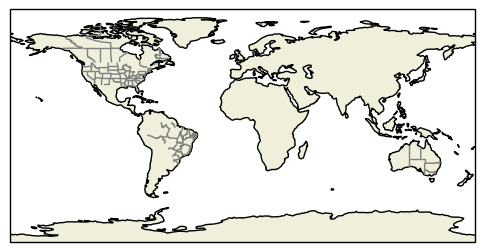

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText


ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([80, 170, -45, 30])

# Put a background image on for nice sea rendering.
#ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

# Add a text annotation for the license information to the
# the bottom right corner.
text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                    ''.format(SOURCE, LICENSE),
                    loc=4, prop={'size': 12}, frameon=True)
# ax.add_artist(text)

plt.show()

In [22]:
def plot_cmap(cmap, vmax=100, filter=lambda x,y: x+y <= 100, foo=1):
    n=(vmax+1)//foo
    xs = np.linspace(0, vmax, n)
    xv, yv = np.meshgrid(xs, xs)
    colors = np.zeros([n,n]).tolist()
    grid = np.dstack((xv, yv))
    ps = []
    for i in range(n):
        for j in range(n):
            x,y = (xv[j,i], yv[j,i])
            if filter(x,y):
                res = cmap((x,y))
                if res is None or np.any(np.isnan(res)):
                    res = (0,0,0)
                if np.any(np.isnan(res)):
                    print((x,y), res)
                colors[j][i] = res
            else:
                colors[j][i] = (0,0,0)
#     print(colors)
    plt.imshow(colors, origin='lower')
    plt.show()

In [24]:
t = np.dtype([('x', float), ('y', float)])
a = np.array([(1,2), (3,4)], dtype=t)
a[1]['x']

3.0

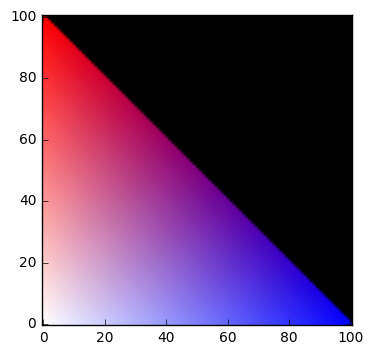

In [26]:
# generate corners of regular n-poly centered at 0,0
def poly_corners(n):
    step = 2*math.pi/n
    return np.array([[math.cos(step*i), math.sin(step*i)] for i in range(n)])

def regular_simplex(n):
    # TODO: implement general approach to compute regular n-simplex
    # https://en.wikipedia.org/wiki/Simplex#Cartesian_coordinates_for_regular_n-dimensional_simplex_in_Rn
    if n==3: return poly_corners(3)
    if n==4: return np.array([
                [1,0,0],
                [-1/3,math.sqrt(8)/3,0],
                [-1/3,-math.sqrt(2)/3,math.sqrt(2/3)],
                [-1/3,-math.sqrt(2)/3,-math.sqrt(2/3)]
                             ])
    if n==5: return np.array([
                [1,0,0,0],
                [-1/4,math.sqrt(15)/4,0,0],
                [-1/4,-math.sqrt(15)/12,math.sqrt(10/12),0],
                [-1/4,-math.sqrt(15)/12,-math.sqrt(30)/12,-math.sqrt(10)/4],
                [-1/4,-math.sqrt(15)/12,-math.sqrt(30)/12,math.sqrt(10)/4]
                             ])

def homogenize(points, out_dim):
    n = len(points)
    res = np.array(points)
    in_dim = len(points[0])
    if in_dim < out_dim:
        res = np.concatenate((res, np.zeros((n,out_dim-in_dim))), axis=1)
    return np.concatenate((res,np.ones((n,1))), axis=1)

def project(a,b):
    a_ = np.array(a)
    b_ = np.array(b)
    return np.dot(a_.T,b_)/np.dot(a_.T,a_)*a_

def gen_cmap(points, colors, lower=0):
    n = len(points)
    a = homogenize(points,n-1)
    b = regular_simplex(n)
#     b = poly_corners(n)
#     print(n,a,b)
#     x = la.solve(a,b)
    x = la.lstsq(a,b)[0]
#     print(x, np.dot(a,x), b)
#     max_dist = la.norm(b[0]-b[1])
    max_dist = la.norm(project(-b[0], b[1]-b[0]))
#     print(max_dist)
    def cmap(ps):
        if len(np.array(ps).shape) == 1:
            ps = [ps]
        a = homogenize(ps,n-1)
#         print(a, x)
        nps = np.dot(a,x)
#         print(nps)
#         distances = [[max(max_dist-la.norm(p-c),0) for c in b] for p in nps]
        distances = [[max(max_dist-la.norm(project(-c, p-c)), 0) for c in b] for p in nps]
        norm_dist = [np.array(k)/sum(k) for k in distances]
        out = np.dot(norm_dist, colors).clip(min=0.0, max=1.0)
#         print(ps, nps.tolist(), distances, out)
        return out.tolist()[0]
    return cmap

# print(project([-1,-1,-1], [1,2,3]))
cmap = gen_cmap([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[100,0], [100,100], [0,100], [0,0]], [(0,0,1), (1,1,1), (1,0,0), (0,0,0)])

# basis
#cmap = gen_cmap([[60,35], [100,0], [0,100], [35,60]], [(1,1,1), (0,0,1), (1,0,0), (1,1,1)])
# better resolution of red v blue
# cmap = gen_cmap([[60,35], [100,0], [0,100], [35,60]], [(0.75,0.75,1), (0,0,1), (1,0,0), (1,0.75,0.75)])

## tests
# cmap = gen_cmap([[50,45], [100,0], [55,55], [0,100], [45,50]], [(1,1,1), (0,0,1), (1,1,1), (1,0,0), (1,1,1)])
# cmap = gen_cmap([[50,45], [100,0], [0,100], [45,50]], [(0,0,1,0), (0,0,1,1), (1,0,0,1), (1,0,0,0)])
# cmap = gen_cmap([[100,0], [100,100], [0,100], [0,0]], [[0.9803921568627451, 0.22745098039215686, 0.0],
#  [0.0, 0.09803921568627451, 0.8823529411764706],
#  [0.44313725490196076, 0.0, 0.9803921568627451],
#  [0.9882352941176471, 0.7254901960784313, 0.0]])

plot_cmap(cmap)
# plot_cmap(cmap, filter=lambda x,y: 95 <= x+y <= 100)

In [27]:
# 2D colormap, as ternary plot
# Barycentric coordinate approach (https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Interpolation_on_a_triangular_unstructured_grid)
# aka treat it as a ternary plot https://en.wikipedia.org/wiki/Ternary_plot

def homogenize(points):
    n = len(points)
    res = np.array(points)
    return np.concatenate((res,np.ones((n,1))), axis=1)

def gen_cmap(coords, colors):
    a = homogenize(coords).T
    def cmap(point):
        b = homogenize([point]).T
#         bpoints = la.solve(a,b)
        bpoints = la.lstsq(a,b)[0]
#         print(bpoints)
        if any(bpoints < -1e-08):
            return None
        return np.dot(bpoints.T,colors)[0]
    return cmap

cmap = gen_cmap([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
cmap = gen_cmap([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])

# plot_cmap(cmap)

[ 1.    0.92  0.92]


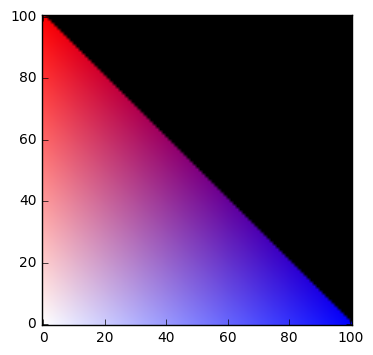

In [43]:
import itertools as itools

cmaps = []
def gen_cmap4(coords, values):
    for indices in itools.combinations(range(len(coords)), 3):
        cmaps.append(gen_cmap([coords[i] for i in indices], [values[i] for i in indices]))
    def cmap(point):
        outs = []
        for cmap in cmaps:
            res = cmap(point)
            if res is not None:
                outs.append(res)
#         print(outs)
        return np.mean(outs,axis=0)
    return cmap

def gen_cmap5(coords, values):
    max_dist = math.sqrt(2*100**2)
    def cmap(ps):
        if len(np.array(ps).shape) == 1:
            ps = [ps]
        distances = [[max(max_dist-la.norm(np.array(p)-np.array(c)), 0) for c in coords] for p in ps]
        norm_dist = [np.array(k)/sum(k) for k in distances]
        out = np.dot(norm_dist, values).clip(min=0.0, max=1.0)
#         print(ps, nps.tolist(), distances, out)
        return out.tolist()[0]
    return cmap

# cmap = gen_cmap4([[10,0], [100,0], [100,100], [10,100]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)])
# cmap = gen_cmap4([[47.5, 47.5], [95,0], [100,0], [0,100], [0,95]], [(1,1,1), (0,0.75,1), (0,0,1), (1,0,0), (1,0.75,0)])
cmap = gen_cmap4([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
# cmap = gen_cmap4([[50*(x+1) for x in p] for p in poly_corners(5)], [(0,0,0), (0,0,1), (1,0,0), (0,1,0), (1,1,1)])
#cmap = gen_cmap4([[50*(x+1) for x in p] for p in poly_corners(6)], [(0,0,1), (0,1,1), (0,1,0), (1,1,0), (1,0,0), (1,0,1)])

print(cmap((0,8)))

# print([x for x in itools.combinations(range(4),3)])
plot_cmap(cmap, filter= lambda x,y:x+y<=100, foo=1)
# for cmap in cmaps:
#     plot_cmap(cmap, filter= lambda x,y:True, foo=4)

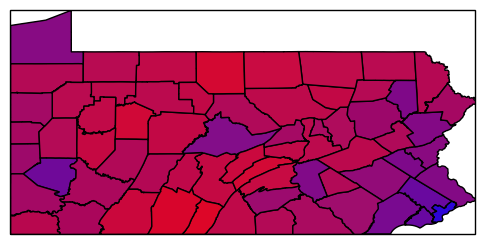

In [661]:
ax = plt.axes(projection=ccrs.PlateCarree())


# fig = plt.figure()#figsize=(8, 3))
# ax = fig.add_axes([0.05, 0.05, 0.85, 0.9], projection=ccrs.PlateCarree())
# ax2 = fig.add_axes([0.925, 0.15, 0.05, 0.7])

# ax = plt.axes(projection=ccrs.PlateCarree())
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[95,0], [100,0], [0,100], [0,95]], [(0,0,1), (0,0,1), (1,0,0), (1,0,0)])

# values = []
# for county,v in COUNTY_RESULTS.items():
#     meta = dict(COUNTY_RESULTS[k])
#     del meta["County"]
#     total = sum([int(f) for f in meta.values()])
#     vap = int(dict(VOTERS[k])["ALL"])
#     value = int(meta["TRUMP, DONALD J"])/sum([int(VOTERS[k]["REP"]), int(VOTERS[k]["OTH"]), int(VOTERS[k]["NOF"])])

for k,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[k]
    total = sum(meta.values())
    clinton = meta[CLINTON]
    trump = meta[TRUMP]
    point = [clinton/total*100, trump/total*100]
    (x,y) = point
    if 95>x+y:
        print (k, x,y)
    color = cmap(point)
    cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree())
    ax.add_feature(cf, facecolor=color)

ax.set_extent([-80.5198510000000027,-74.7215190000000007,39.7211469999999949,42.5160720000000012])
ax.set_aspect(1)

# cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=colormap, norm=colors.Normalize(vmin=0, vmax=1), extend='max')

plt.show()

In [409]:
PAPER = 0
MIXED = 1
DRE = 2

VOTE_METHOD = {
"Adams": PAPER,
"Allegheny": DRE,
"Armstrong": DRE,
"Beaver": DRE,
"Bedford": MIXED,
"Berks": DRE,
"Blair": DRE,
"Bradford": DRE,
"Bucks": DRE,
"Butler": DRE,
"Cambria": DRE,
"Cameron": DRE,
"Carbon": DRE,
"Centre": PAPER,
"Chester": MIXED,
"Clarion": DRE,
"Clearfield": DRE,
"Clinton": DRE,
"Columbia": MIXED,
"Crawford": DRE,
"Cumberland": MIXED,
"Dauphin": DRE,
"Delaware": DRE,
"Elk": DRE,
"Erie": DRE,
"Fayette": MIXED,
"Forest": DRE,
"Franklin": PAPER,
"Fulton": PAPER,
"Greene": DRE,
"Huntingdon": PAPER,
"Indiana": PAPER,
"Jefferson": DRE,
"Juniata": PAPER,
"Lackawanna": PAPER,
"Lancaster": MIXED,
"Lawrence": DRE,
"Lebanon": DRE,
"Lehigh": DRE,
"Luzerne": MIXED,
"Lycoming": DRE,
"Mckean": DRE,
"Mercer": DRE,
"Mifflin": PAPER,
"Monroe": DRE,
"Montgomery": DRE,
"Montour": PAPER,
"Northampton": DRE,
"Northumberland": DRE,
"Perry": DRE,
"Philadelphia": DRE,
"Pike": DRE,
"Potter": DRE,
"Schuylkill": DRE,
"Snyder": PAPER,
"Somerset": DRE,
"Sullivan": DRE,
"Susquehanna": PAPER,
"Tioga": DRE,
"Union": DRE,
"Venango": DRE,
"Warren": DRE,
"Washington": DRE,
"Wayne": PAPER,
"Westmoreland": MIXED,
"Wyoming": DRE,
"York": DRE
}

-2.45373136105


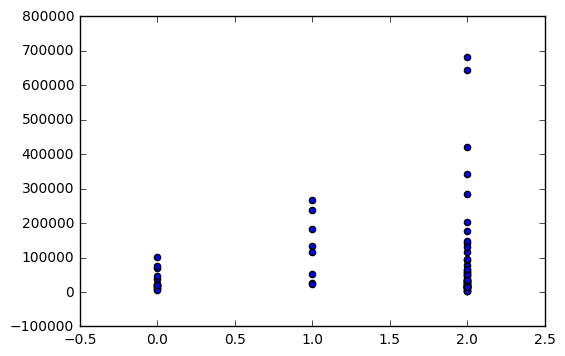

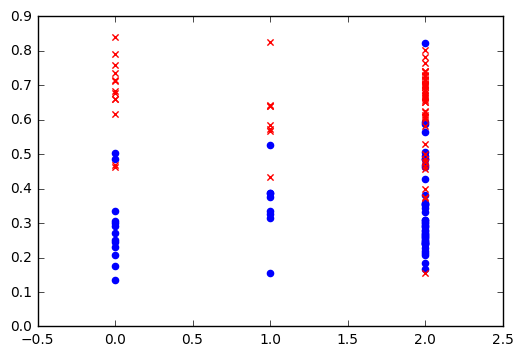

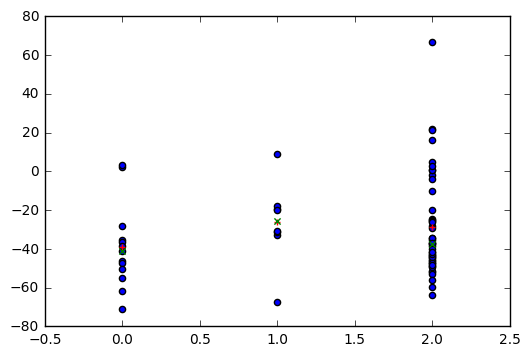

In [429]:
counties = VOTE_METHOD.keys()
x = [VOTE_METHOD[c] for c in counties]
totals = []
clinton = []
trump = []
delta = []
for c in counties:
    meta = dict(COUNTY_RESULTS[c])
    del meta["County"]
    total = sum([int(f) for f in meta.values()])
    totals.append(total)
    clinton.append(int(meta[CLINTON])/total)
    trump.append(int(meta[TRUMP])/total)
    delta.append((clinton[-1]-trump[-1])*100)
plt.figure()
plt.scatter(x,y)
plt.figure()
plt.scatter(x,clinton, color='blue')
plt.scatter(x,trump, color='red', marker='x')
plt.figure()
plt.scatter(x,delta)
d = np.array(delta)
k = np.array(x)

means_x = list(set(x))
means = [stat.mean(d[k==i]) for i in means_x]
medians = [stat.median(d[k==i]) for i in means_x]
plt.scatter(means_x, means, marker='+', color='red')
plt.scatter(means_x, medians, marker='x', color='green')
print(means[2]-means[1])
plt.show()

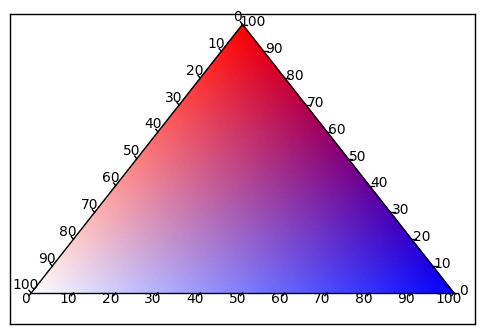

In [471]:
scale=100

data = dict()
for (i, j, k) in simplex_iterator(scale):
    data[(i, j, k)] = cmap((i,j))

figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", colormap=False) # Allow colors as rgba tuples
tax.boundary()

tax.ticks(axis='lbr', multiple=10, linewidth=1)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()

plt.show()